# CAS AML project: module 1 and 2
**Author:** Adyl El Guamra 

**Date:** 23/09/2025


# CIFAR-10 Dataset

- CIFAR-10 is a well-known benchmark dataset in computer vision.  
- It contains 60,000 color images, each of size 32×32 pixels.  
- There are 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.  
- The dataset is split into:
  - 50,000 training images
  - 10,000 test images

---

## Machine Learning Problem

- **Type**: Supervised image classification  
- **Task**: Learn to map image pixels to one of the 10 class labels.  
- **Goal**: Train a model that correctly predicts the class of unseen test images.  
- **Challenge**:  
  - Low resolution makes feature extraction harder.  
  - Some classes are visually similar (e.g., cat vs. dog, truck vs. automobile).  
- **Use case for feature extractors**: Models can be trained to extract meaningful features from the images, which can then be used for classification or transferred to other tasks.

## Pretrained Models

- In TensorFlow (via `tf.keras.applications`), pretrained models are trained on **ImageNet** (1.2M images, 1000 classes).  
- Popular choices include **MobileNetV2**, **EfficientNet**, **ResNet50**, and **InceptionV3**.  
- These models expect **larger input sizes** (usually 224×224 pixels or higher).  
  - To use them with CIFAR-10 (32×32), images must be **resized** to match the model’s expected input.  
- Each model comes with a dedicated `preprocess_input` function that prepares images (scaling and normalization) consistently with how the model was trained.  
- When used as **feature extractors**, we remove the final classification layer and keep the intermediate representation (embedding).  
  - These embeddings capture **general visual patterns** (edges, textures, object parts) learned from ImageNet.  
  - They can then be used to train a **new classifier** on CIFAR-10, or compared with **classical models** like Logistic Regression, SVM, kNN, or Random Forest.  

### Why use pretrained models?
- **Faster convergence**: We start from general-purpose vision features instead of random weights.  
- **Better accuracy**: Even though CIFAR-10 is small, ImageNet-pretrained features transfer well.  
- **Flexibility**: Embeddings can be reused for other datasets or tasks beyond CIFAR-10.  

---



 # Import the packages

In [86]:
# Standard library
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Magic command
%matplotlib inline

# Loading the dataset

In [58]:
# Training set
X_train_valid: np.ndarray
y_train_valid: np.ndarray

# Test set
X_test: np.ndarray
y_test: np.ndarray

# Loading the dataset: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data
(X_train_valid, y_train_valid), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [59]:
from sklearn.model_selection import train_test_split

# Validation set
X_valid: np.ndarray
y_valid: np.ndarray

# Create a valid set for models hyperparameters tuning
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, y_train_valid, test_size=0.20, random_state=42)

print("Train set:")
print(f"  X_train: shape={X_train.shape}, dtype={X_train.dtype}")
print(f"  y_train: shape={y_train.shape}, dtype={y_train.dtype}")

print("\n Valid pset:")
print(f"  X_valid: shape={X_valid.shape}, dtype={X_valid.dtype}")
print(f"  y_valid: shape={y_valid.shape}, dtype={y_valid.dtype}")

print("\n Test set:")
print(f"  X_test:        shape={X_test.shape}, dtype={X_test.dtype}")
print(f"  y_test:        shape={y_test.shape}, dtype={y_test.dtype}")

Train set:
  X_train: shape=(40000, 32, 32, 3), dtype=uint8
  y_train: shape=(40000, 1), dtype=uint8

 Valid pset:
  X_valid: shape=(10000, 32, 32, 3), dtype=uint8
  y_valid: shape=(10000, 1), dtype=uint8

 Test set:
  X_test:        shape=(10000, 32, 32, 3), dtype=uint8
  y_test:        shape=(10000, 1), dtype=uint8


# Data preparation
* Get the map of labels
* Get the valid set

In [60]:
unique_labels: list[int] = list(np.unique(y_train_valid))
print(f'The list of unique label: {unique_labels}')

first_occurence_indices: list[int] = []

# Get the list of index for the first labels
for label in unique_labels:
    for idx in range(len(y_train_valid)):
        if y_train_valid[idx] == label:
           first_occurence_indices.append(idx)
           break
print(f'The first labels in increasing order:{first_occurence_indices}')

The list of unique label: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
The first labels in increasing order:[29, 4, 6, 9, 3, 27, 0, 7, 8, 1]


In [61]:
# https://www.cs.toronto.edu/~kriz/cifar.html
CLASS_NAMES: list[str] = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

label_to_class: dict[int, str] = dict(zip(unique_labels, CLASS_NAMES))

print("The map between label and class name:", label_to_class)

The map between label and class name: {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


airplane


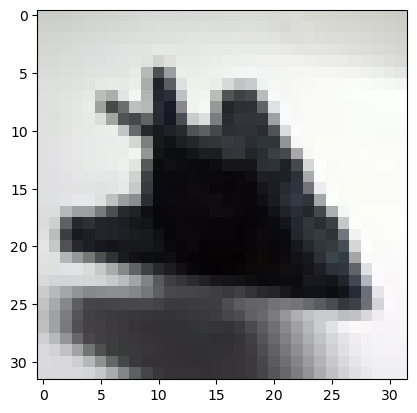

automobile


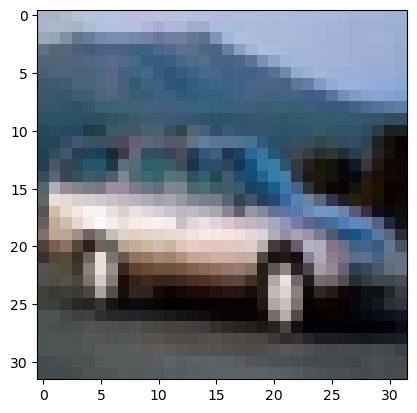

bird


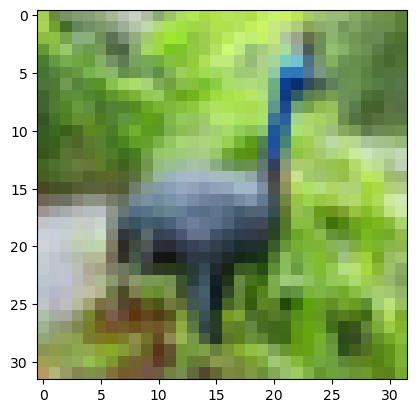

cat


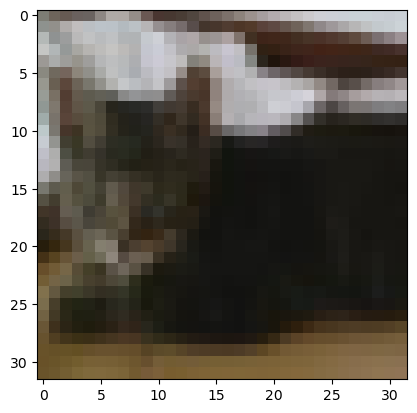

deer


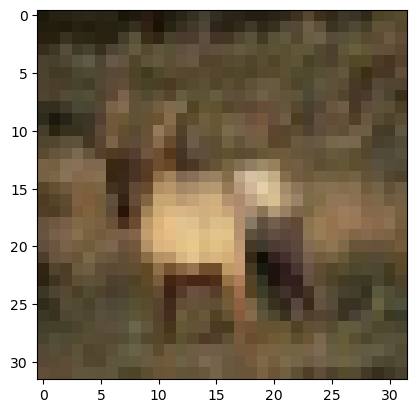

dog


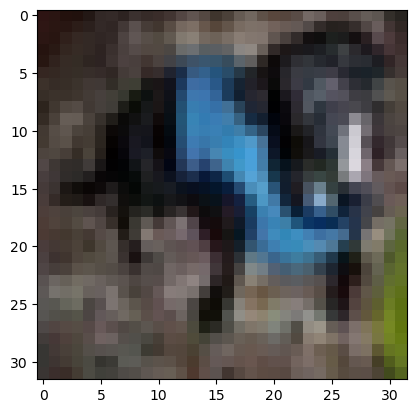

frog


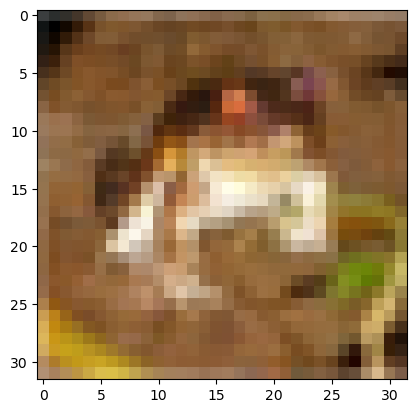

horse


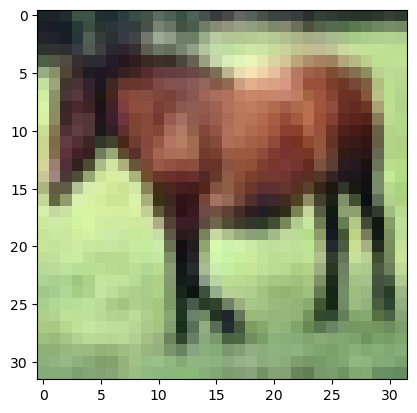

ship


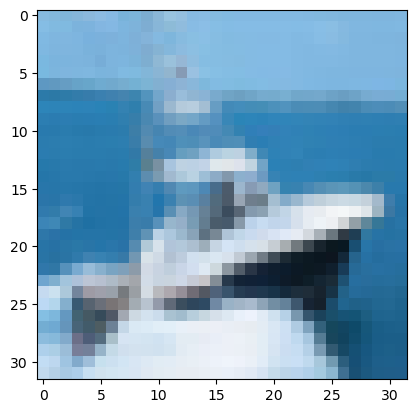

truck


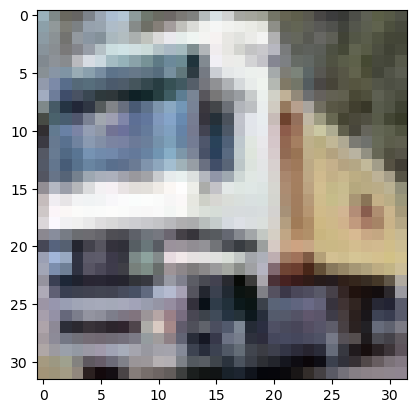

In [62]:
def print_imgs(img_nbrs: list[int]) -> None:
    for img_nbr in img_nbrs:
        print(label_to_class[y_train_valid[img_nbr].item()])
        plt.imshow(X_train_valid[img_nbr])
        plt.show()  # ensures each image is displayed separately

# Print the first occurence of each class
print_imgs(first_occurence_indices)

**Note**: The images have a low resolution

# Feature engineering

## Extact features from images
- https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
- https://keras.io/api/applications/#extract-features-from-an-arbitrary-intermediate-layer-with-vgg19
- https://keras.io/api/applications/#usage-examples-for-image-classification-models


In [63]:
IMG_SIZE = 160 # origninal img size (32, 32, 3), optimal img size (224, 224, 3)

### Feature extractor

In [ ]:
from tensorflow import keras
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.models import Model

# Load the model without the fully connected layer 
backbone: Model = MobileNetV2(
    weights="imagenet", 
    include_top=False, pooling="avg",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
backbone.trainable = False

# Build the feature extractor
feature_extractor: Model = tf.keras.Sequential()
feature_extractor.add(keras.layers.Input(shape=(32, 32, 3), dtype=tf.uint8))
feature_extractor.add(keras.layers.Resizing(IMG_SIZE, IMG_SIZE, interpolation="bilinear"))
feature_extractor.add(keras.layers.Lambda(lambda x: preprocess_input(tf.cast(x, tf.float32))))
feature_extractor.add(backbone)

# Extract features
feat_train: np.ndarray = feature_extractor.predict(X_train, batch_size=256, verbose=0)  # (N_train, 1280)
feat_valid: np.ndarray = feature_extractor.predict(X_valid, batch_size=256, verbose=0)  # (N_valid, 1280)
feat_test: np.ndarray  = feature_extractor.predict(X_test,  batch_size=256, verbose=0)  # (N_test, 1280)

# Debug prints
print("Type of feat_train:", type(feat_train))
print("Shape of feat_train:", feat_train.shape)
print("feat_train dtype (expected: float32 by default):", feat_train.dtype)

print("Type of feat_valid:", type(feat_valid))
print("Shape of feat_valid:", feat_valid.shape)
print("feat_valid dtype (expected: float32 by default):", feat_valid.dtype)

print("Type of feat_test:", type(feat_test))
print("Shape of feat_test:", feat_test.shape)
print("feat_test dtype (expected: float32 by default):", feat_train.dtype)

2025-09-18 16:28:22.171967: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Type of feat_train: <class 'numpy.ndarray'>
Shape of feat_train: (40000, 1280)
feat_train dtype (expected: float32 by default): float32
Type of feat_valid: <class 'numpy.ndarray'>
Shape of feat_valid: (10000, 1280)
feat_valid dtype (expected: float32 by default): float32
Type of feat_test: <class 'numpy.ndarray'>
Shape of feat_test: (10000, 1280)
feat_test dtype (expected: float32 by default): float32


### Save features

In [64]:
from pathlib import Path

# Path to ../features relative to current working directory
features_dir: Path = (Path.cwd() / ".." / "features").resolve()
features_dir.mkdir(exist_ok=True)

In [ ]:
# Labels: flatten to 1-D
y_train_1d: np.ndarray = np.asarray(y_train).ravel().astype(np.int64)
y_valid_1d: np.ndarray = np.asarray(y_valid).ravel().astype(np.int64)
y_test_1d:  np.ndarray = np.asarray(y_test).ravel().astype(np.int64)

# Save the features and metadata as a single compressed NPZ
out_path: Path = features_dir / f"mobilenetv2_{IMG_SIZE}_features.npz"
np.savez_compressed(
    file = out_path,
    feat_train=feat_train,
    feat_valid=feat_valid,
    feat_test=feat_test,
    y_train=y_train_1d,
    y_valid=y_valid_1d,
    y_test=y_test_1d,
    backbone=np.array(["MobileNetV2"], dtype=object),
    img_size=np.array([IMG_SIZE], dtype=np.int32),
    dtype=np.array([str(feat_train.dtype)], dtype=object),
)
print("Saved to:", out_path)

Saved to: /mnt/c/Users/aelgu.adyx/Documents/unibe/m1_2_prj_cas_aml/features/mobilenetv2_160_features.npz


# Models training

## Load features

In [65]:
# Load features and labels from file
bundle = np.load(features_dir / f"mobilenetv2_{IMG_SIZE}_features.npz", allow_pickle=True)

# Take features (vectors) and labels
feat_train = bundle["feat_train"]
feat_valid = bundle["feat_valid"]
feat_test  = bundle["feat_test"]
y_train_1d = bundle["y_train"]
y_valid_1d = bundle["y_valid"]
y_test_1d  = bundle["y_test"]

# Print shape and dtype for check
print("feat_train:", feat_train.shape, feat_train.dtype)
print("feat_valid:", feat_valid.shape, feat_valid.dtype)
print("feat_test :", feat_test.shape,  feat_test.dtype)
print("y_train  :", y_train_1d.shape, y_train_1d.dtype)
print("y_valid  :", y_valid_1d.shape, y_valid_1d.dtype)
print("y_test   :", y_test_1d.shape,  y_test_1d.dtype)

feat_train: (40000, 1280) float32
feat_valid: (10000, 1280) float32
feat_test : (10000, 1280) float32
y_train  : (40000,) int64
y_valid  : (10000,) int64
y_test   : (10000,) int64


## Sklearn models

### Import sklearn packages

In [67]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

### Helper function

In [68]:
def evaluate_classifier(
    clf, # scikit-learn classifier or pipeline
    X: np.ndarray, 
    y: np.ndarray, 
    name: str="Model")->None:
    
    y_predicted = clf.predict(X)
    print(f"[{name}] Accuracy:", accuracy_score(y, y_predicted))
    print(classification_report(y, y_predicted, digits=4))
    return None

### Dummy classifier

In [87]:
# Create a baseline with dummy classifier to compare with other models
# The uniform strategy: ignores the data and just picks a label at random, with equal probability for each class.
dummy_clf: DummyClassifier  = DummyClassifier(strategy="uniform") 
dummy_clf.fit(feat_train, y_train_1d)

# Evaluate on validation features (2D)
evaluate_classifier(
    clf=dummy_clf,
    X=feat_valid, 
    y=y_valid_1d,
    name="Dummy classifier"
)

[Dummy classifier] Accuracy: 0.1018
              precision    recall  f1-score   support

           0     0.1169    0.1151    0.1160       973
           1     0.0994    0.0981    0.0987       979
           2     0.1110    0.1117    0.1113      1030
           3     0.1040    0.1036    0.1038      1023
           4     0.0870    0.0965    0.0915       933
           5     0.1024    0.1034    0.1029      1015
           6     0.1047    0.1054    0.1051       996
           7     0.1056    0.1026    0.1041       994
           8     0.0938    0.0944    0.0941      1017
           9     0.0940    0.0875    0.0906      1040

    accuracy                         0.1018     10000
   macro avg     0.1019    0.1018    0.1018     10000
weighted avg     0.1019    0.1018    0.1018     10000



**Note**: 
* Any models that actually learns should beat the current performance.
* Random guess: any class has equal probability.

### Logistic regression

In [70]:
# Logistic Regression (multiclass) + standardization
lr_clf: Pipeline = make_pipeline(
    StandardScaler(),  # scale features improves LR convergence
    LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",          # supports multinomial + n_jobs
        max_iter=500,
        n_jobs=-1,
        random_state=42,
    )
)

# Train on feature vectors (2D)
lr_clf.fit(feat_train, y_train_1d)

# Evaluate on validation features (2D)
evaluate_classifier(clf=lr_clf,
                    X=feat_valid, 
                    y=y_valid_1d,
                    name="Logistic Regression"
)

[Logistic Regression] Accuracy: 0.8271
              precision    recall  f1-score   support

           0     0.8335    0.8284    0.8309       973
           1     0.9088    0.9162    0.9125       979
           2     0.8000    0.7689    0.7842      1030
           3     0.7206    0.7009    0.7106      1023
           4     0.7634    0.8092    0.7856       933
           5     0.7734    0.7567    0.7649      1015
           6     0.8651    0.8695    0.8673       996
           7     0.8328    0.8370    0.8349       994
           8     0.8780    0.8850    0.8815      1017
           9     0.8899    0.9019    0.8959      1040

    accuracy                         0.8271     10000
   macro avg     0.8266    0.8274    0.8268     10000
weighted avg     0.8267    0.8271    0.8268     10000



### Random forest

In [ ]:
# Random Forest classifier
rf_clf: RandomForestClassifier = RandomForestClassifier(
    n_estimators=300,       # number of trees in the forest 
    max_features="sqrt",    # number of features to consider at each split, "sqrt" = sqrt(n_features)
    n_jobs=-1,              # use all CPU cores in parallel
    random_state=42,        # random seed 
)

# Train on feature vectors
rf_clf.fit(feat_train, y_train_1d)

# Evaluate on valid features
evaluate_classifier(clf=rf_clf, 
                    X=feat_valid, 
                    y=y_valid_1d, 
                    name="Random forest")

[Random forest] Accuracy: 0.8184
              precision    recall  f1-score   support

           0     0.8172    0.8088    0.8130       973
           1     0.8943    0.9244    0.9091       979
           2     0.8513    0.7282    0.7849      1030
           3     0.6733    0.6911    0.6821      1023
           4     0.7405    0.8167    0.7768       933
           5     0.7765    0.7360    0.7557      1015
           6     0.8669    0.8896    0.8781       996
           7     0.8326    0.8058    0.8190       994
           8     0.8427    0.8958    0.8684      1017
           9     0.8940    0.8923    0.8932      1040

    accuracy                         0.8184     10000
   macro avg     0.8190    0.8189    0.8180     10000
weighted avg     0.8193    0.8184    0.8180     10000



### SVM

In [72]:
svm_clf: Pipeline = make_pipeline(
    StandardScaler(),
    LinearSVC(dual=False, C=1.0, max_iter=5000, random_state=42)
)

svm_clf.fit(feat_train, y_train_1d)

# Evaluate on valid features
evaluate_classifier(clf=svm_clf, 
                    X=feat_valid, 
                    y=y_valid_1d, 
                    name="SVM")

[SVM] Accuracy: 0.8429
              precision    recall  f1-score   support

           0     0.8422    0.8499    0.8460       973
           1     0.8805    0.9030    0.8916       979
           2     0.8545    0.7922    0.8222      1030
           3     0.7485    0.7185    0.7332      1023
           4     0.7973    0.8349    0.8157       933
           5     0.8032    0.7842    0.7936      1015
           6     0.8898    0.8996    0.8947       996
           7     0.8516    0.8773    0.8642       994
           8     0.8841    0.8850    0.8845      1017
           9     0.8717    0.8885    0.8800      1040

    accuracy                         0.8429     10000
   macro avg     0.8423    0.8433    0.8426     10000
weighted avg     0.8425    0.8429    0.8424     10000



## Tensorflow/keras models


### Import tensorflow/keras packages

In [ ]:
from keras import layers, regularizers, callbacks

### Dense model with one hidden layer

In [74]:
l2: float = 5e-4

# Fully connected classifier model (feedforward)
fc1_clf: keras.Sequential = keras.Sequential([
    keras.Input(shape=(feat_train.shape[1],)),

    layers.Dropout(0.25), # This first dropout layer highly reduces the overfitting
   
    layers.Dense(256, use_bias=False, kernel_regularizer=regularizers.l2(l2)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.5),

    layers.Dense(10, activation="softmax"),
])

fc1_clf.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_8 (Dropout)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               327680    
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 256)               0         
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                2570      
                                                      

In [75]:
fc1_clf.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

cbs: list = [
    callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, min_lr=1e-5, verbose=1),
    callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
]

history_fc1_clf: keras.callbacks.History = fc1_clf.fit(
    feat_train, y_train_1d,
    validation_data=(feat_valid, y_valid_1d),  # use real validation set
    epochs=150,
    batch_size=256,
    callbacks=cbs,
    verbose=1,
)


print("Test accuracy:", fc1_clf.evaluate(feat_test, y_test_1d, verbose=0)[1])

Epoch 1/150
157/157 [==============================] - 8s 38ms/step - loss: 0.9370 - accuracy: 0.7579 - val_loss: 0.6367 - val_accuracy: 0.8485 - lr: 0.0010
Epoch 2/150
157/157 [==============================] - 4s 28ms/step - loss: 0.6833 - accuracy: 0.8276 - val_loss: 0.5708 - val_accuracy: 0.8623 - lr: 0.0010
Epoch 3/150
157/157 [==============================] - 1s 5ms/step - loss: 0.6184 - accuracy: 0.8424 - val_loss: 0.5338 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 4/150
157/157 [==============================] - 4s 25ms/step - loss: 0.5808 - accuracy: 0.8497 - val_loss: 0.5189 - val_accuracy: 0.8657 - lr: 0.0010
Epoch 5/150
157/157 [==============================] - 5s 32ms/step - loss: 0.5472 - accuracy: 0.8564 - val_loss: 0.5018 - val_accuracy: 0.8694 - lr: 0.0010
Epoch 6/150
157/157 [==============================] - 10s 60ms/step - loss: 0.5336 - accuracy: 0.8562 - val_loss: 0.4860 - val_accuracy: 0.8715 - lr: 0.0010
Epoch 7/150
157/157 [==============================] - 7s 

Text(0.5, 0.98, 'Accuracy and loss')

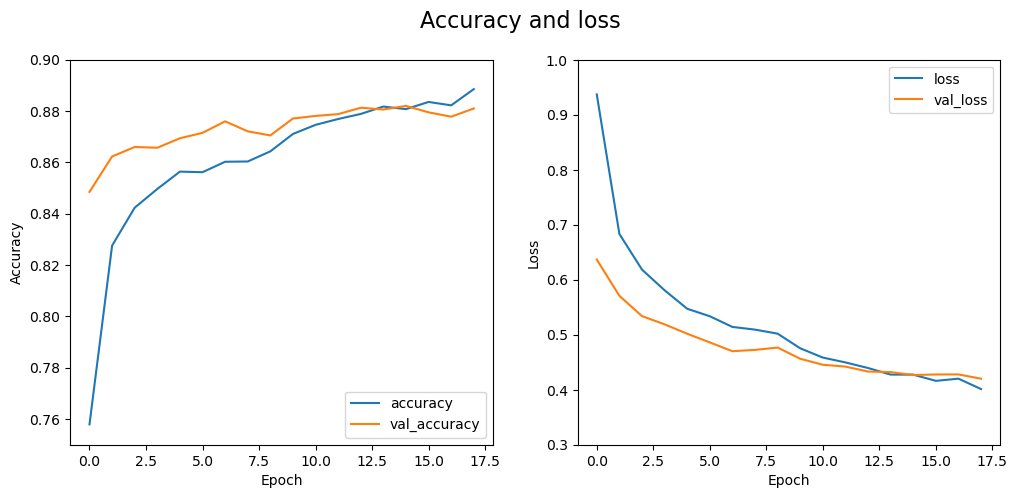

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
ax1.plot(history_fc1_clf.history['accuracy'], label='accuracy')
ax1.plot(history_fc1_clf.history['val_accuracy'], label = 'val_accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0.75, 0.9])
ax1.legend(loc='lower right')

# Loss plot
ax2.plot(history_fc1_clf.history['loss'], label='loss')
ax2.plot(history_fc1_clf.history['val_loss'], label = 'val_loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_ylim([0.3, 1])
ax2.legend(loc='upper right')

fig.suptitle('Accuracy and loss', fontsize=16)

In [ ]:
# Predict class indices
y_prob_fc1 = fc1_clf.predict(feat_test, batch_size=1024, verbose=0)
y_pred_fc1 = np.argmax(y_prob_fc1, axis=1)

# CIFAR-10 class names
CLASS_NAMES = ["airplane","automobile","bird","cat","deer",
               "dog","frog","horse","ship","truck"]

print("Test accuracy (recomputed):", accuracy_score(y_test_1d, y_pred_fc1))
print(classification_report(y_test_1d, y_pred_fc1, digits=4, target_names=CLASS_NAMES))

Test accuracy (recomputed): 0.8794
              precision    recall  f1-score   support

    airplane     0.8936    0.9070    0.9002      1000
  automobile     0.9293    0.9470    0.9381      1000
        bird     0.8495    0.8520    0.8507      1000
         cat     0.7963    0.7270    0.7601      1000
        deer     0.8328    0.8570    0.8448      1000
         dog     0.8470    0.8140    0.8302      1000
        frog     0.8785    0.9400    0.9082      1000
       horse     0.8919    0.8990    0.8954      1000
        ship     0.9278    0.9250    0.9264      1000
       truck     0.9401    0.9260    0.9330      1000

    accuracy                         0.8794     10000
   macro avg     0.8787    0.8794    0.8787     10000
weighted avg     0.8787    0.8794    0.8787     10000



### Dense model with two hidden layer

In [94]:
l2: float = 5e-4

# Fully connected classifier model (feedforward)
fc2_clf: keras.Sequential = keras.Sequential([
    keras.Input(shape=(feat_train.shape[1],)),

    layers.Dropout(0.25), # This first dropout layer highly reduces the overfitting
   
    layers.Dense(256, use_bias=False, kernel_regularizer=regularizers.l2(l2)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.5),
    
    layers.Dense(256, use_bias=False, kernel_regularizer=regularizers.l2(l2)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.5),

    layers.Dense(10, activation="softmax"),
])

fc2_clf.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_9 (Dropout)         (None, 1280)              0         
                                                                 
 dense_9 (Dense)             (None, 256)               327680    
                                                                 
 batch_normalization_6 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 256)               0         
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               65536     
                                                      

In [95]:
fc2_clf.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

cbs: list = [
    callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, min_lr=1e-5, verbose=1),
    callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
]

history_fc2_clf: keras.callbacks.History = fc2_clf.fit(
    feat_train, y_train_1d,
    validation_data=(feat_valid, y_valid_1d),  # use real validation set
    epochs=150,
    batch_size=256,
    callbacks=cbs,
    verbose=1,
)


print("Test accuracy:", fc2_clf.evaluate(feat_test, y_test_1d, verbose=0)[1])

Epoch 1/150
157/157 [==============================] - 10s 51ms/step - loss: 1.2870 - accuracy: 0.6861 - val_loss: 0.8015 - val_accuracy: 0.8351 - lr: 0.0010
Epoch 2/150
157/157 [==============================] - 5s 34ms/step - loss: 0.8957 - accuracy: 0.8033 - val_loss: 0.7190 - val_accuracy: 0.8493 - lr: 0.0010
Epoch 3/150
157/157 [==============================] - 6s 35ms/step - loss: 0.7985 - accuracy: 0.8213 - val_loss: 0.6569 - val_accuracy: 0.8576 - lr: 0.0010
Epoch 4/150
157/157 [==============================] - 5s 32ms/step - loss: 0.7416 - accuracy: 0.8311 - val_loss: 0.6189 - val_accuracy: 0.8632 - lr: 0.0010
Epoch 5/150
157/157 [==============================] - 6s 36ms/step - loss: 0.6916 - accuracy: 0.8384 - val_loss: 0.5880 - val_accuracy: 0.8657 - lr: 0.0010
Epoch 6/150
157/157 [==============================] - 5s 32ms/step - loss: 0.6653 - accuracy: 0.8385 - val_loss: 0.5752 - val_accuracy: 0.8652 - lr: 0.0010
Epoch 7/150
157/157 [==============================] - 5s

Text(0.5, 0.98, 'Accuracy and loss')

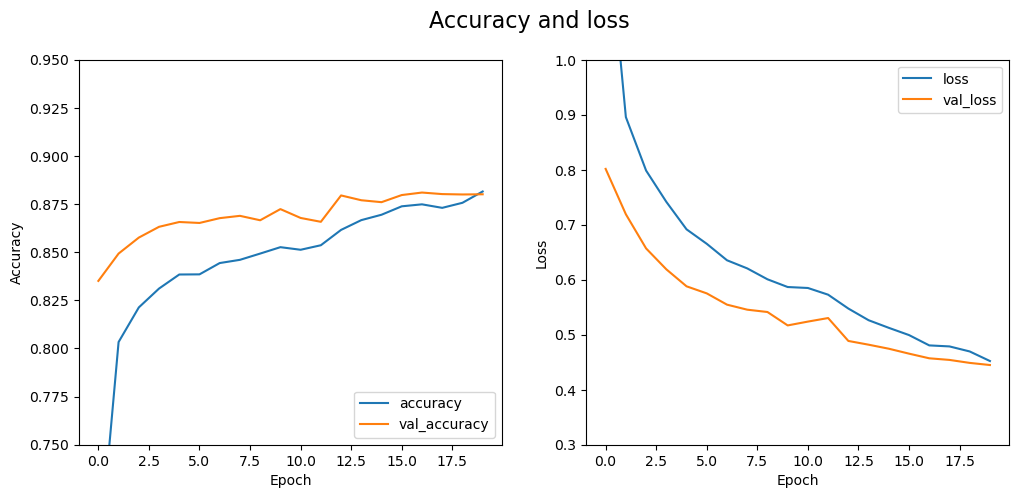

In [96]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
ax1.plot(history_fc2_clf.history['accuracy'], label='accuracy')
ax1.plot(history_fc2_clf.history['val_accuracy'], label = 'val_accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0.75, 0.95])
ax1.legend(loc='lower right')

# Loss plot
ax2.plot(history_fc2_clf.history['loss'], label='loss')
ax2.plot(history_fc2_clf.history['val_loss'], label = 'val_loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_ylim([0.3, 1])
ax2.legend(loc='upper right')

fig.suptitle('Accuracy and loss', fontsize=16)

In [97]:
# Predict class indices
y_prob_fc2 = fc2_clf.predict(feat_test, batch_size=1024, verbose=0)
y_pred_fc2 = np.argmax(y_prob_fc2, axis=1)

# CIFAR-10 class names
CLASS_NAMES = ["airplane","automobile","bird","cat","deer",
               "dog","frog","horse","ship","truck"]

print("Test accuracy (recomputed):", accuracy_score(y_test_1d, y_pred_fc2))
print(classification_report(y_test_1d, y_pred_fc2, digits=4, target_names=CLASS_NAMES))

Test accuracy (recomputed): 0.8796
              precision    recall  f1-score   support

    airplane     0.8979    0.8970    0.8974      1000
  automobile     0.9445    0.9190    0.9316      1000
        bird     0.8927    0.8400    0.8655      1000
         cat     0.7592    0.7820    0.7704      1000
        deer     0.8303    0.8660    0.8478      1000
         dog     0.8505    0.8190    0.8344      1000
        frog     0.9031    0.9230    0.9130      1000
       horse     0.8940    0.8860    0.8900      1000
        ship     0.9228    0.9210    0.9219      1000
       truck     0.9067    0.9430    0.9245      1000

    accuracy                         0.8796     10000
   macro avg     0.8802    0.8796    0.8797     10000
weighted avg     0.8802    0.8796    0.8797     10000



### KerasTuner 
https://keras.io/keras_tuner/getting_started/

In [82]:
import keras_tuner as kt

In [ ]:
# Step 1: Build function with hp for hyperparameters
def build_fc2_model_hp(hp: kt.HyperParameters) -> keras.Model:
    lr: float     = hp.Choice("lr", [1e-3, 5e-4, 2e-4])
    l2_reg: float = hp.Choice("l2_reg", [1e-4, 5e-4, 1e-3])

    units: int = 256          # fixed capacity
    d1: float = 0.25          # fixed dropout
    d2: float = 0.50

    model: keras.Model = keras.Sequential([
        keras.Input(shape=(feat_train.shape[1],)),
        layers.Dropout(d1),

        layers.Dense(units, use_bias=False, kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(), layers.Activation("relu"), layers.Dropout(d2),

        layers.Dense(units, use_bias=False, kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(), layers.Activation("relu"), layers.Dropout(d2),

        layers.Dense(10, activation="softmax"),
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


# Step 2: Create the GridSearch tuner
tuner: kt.GridSearch = kt.GridSearch(
    hypermodel=build_fc2_model_hp,
    objective="val_accuracy",
    seed=42,
    directory="kt_logs",
    project_name="fc2_grid",
    overwrite=True,
)

# Step 3: Run the search
tuner.search(
    feat_train, y_train_1d,
    validation_data=(feat_valid, y_valid_1d),
    epochs=50,
    batch_size=256,
    callbacks=[
        callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5,
                                    patience=2, min_lr=1e-5, verbose=1),
        callbacks.EarlyStopping(monitor="val_accuracy", patience=3,
                                restore_best_weights=True),
    ],
    verbose=1,
)

# Step 4: Retrieve best result and evaluate on test set
best_hp: kt.HyperParameters = tuner.get_best_hyperparameters(1)[0]
best_model: keras.Model = tuner.get_best_models(1)[0]   # already built & trained
test_loss, test_acc = best_model.evaluate(feat_test, y_test_1d, verbose=0)
print("Best HPs:", best_hp.values)
print("Test accuracy:", float(test_acc))


Trial 9 Complete [00h 02m 23s]
val_accuracy: 0.8754000067710876

Best val_accuracy So Far: 0.8842999935150146
Total elapsed time: 01h 09m 40s
Best HPs: {'lr': 0.001, 'l2_reg': 0.0005}
Test accuracy: 0.8831999897956848


In [85]:
from sklearn.metrics import classification_report

# Predictions → class labels
y_prob = best_model.predict(feat_test, batch_size=256, verbose=0)
y_pred = y_prob.argmax(axis=1)

print("\nClassification report:\n")
print(classification_report(y_test_1d, y_pred, digits=4))



Classification report:

              precision    recall  f1-score   support

           0     0.8943    0.9050    0.8996      1000
           1     0.9308    0.9410    0.9359      1000
           2     0.9046    0.8340    0.8678      1000
           3     0.7626    0.7840    0.7732      1000
           4     0.8330    0.8730    0.8525      1000
           5     0.8504    0.8240    0.8370      1000
           6     0.9040    0.9230    0.9134      1000
           7     0.9048    0.8930    0.8988      1000
           8     0.9187    0.9270    0.9228      1000
           9     0.9345    0.9280    0.9313      1000

    accuracy                         0.8832     10000
   macro avg     0.8838    0.8832    0.8832     10000
weighted avg     0.8838    0.8832    0.8832     10000



# Results and interpretations

## Confusion matrix

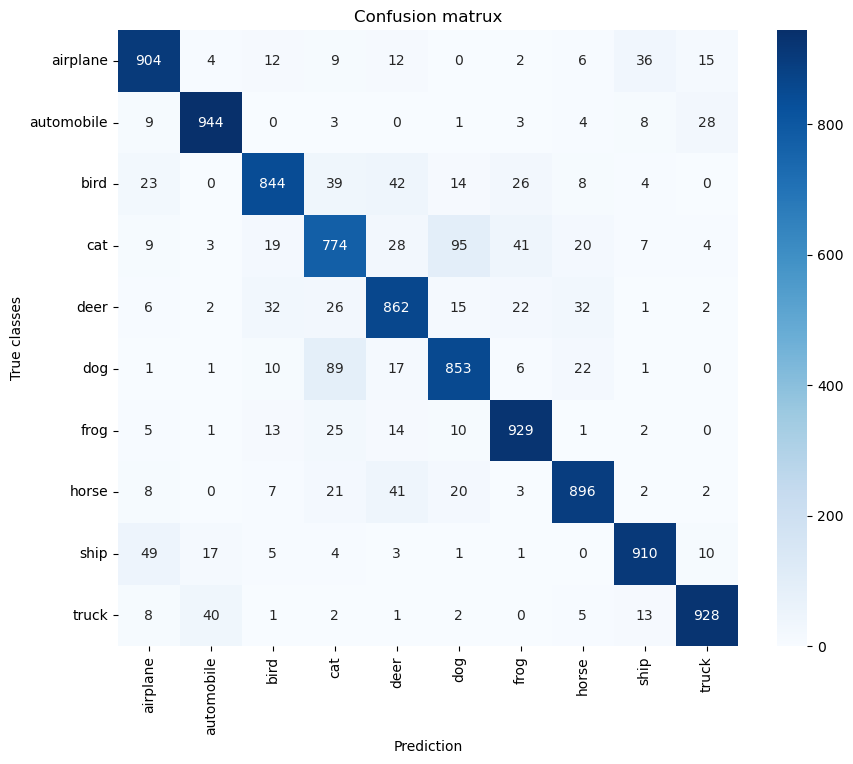

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix: np.ndarray = confusion_matrix(y_test_1d, y_pred_fc2)

# print the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Prediction')
plt.ylabel('True classes')
plt.title('Confusion matrux')
plt.show()

## Error analysis

In [27]:
# Results form the best model
report_dict = classification_report(
    y_test_1d, y_pred_fc2,
    digits=4,
    target_names=CLASS_NAMES,
    output_dict=True
)

print(report_dict)


error_rates = {}
for cls in CLASS_NAMES:
    recall = report_dict[cls]["recall"]     # per-class recall = correct/total for that class
    error_rates[cls] = 1.0 - recall

print("Error rate per class:")
for cls in CLASS_NAMES:
    print(f"{cls}: {error_rates[cls]:.4f}")

{'airplane': {'precision': 0.8845401174168297, 'recall': 0.904, 'f1-score': 0.8941641938674579, 'support': 1000.0}, 'automobile': {'precision': 0.932806324110672, 'recall': 0.944, 'f1-score': 0.9383697813121272, 'support': 1000.0}, 'bird': {'precision': 0.8950159066808059, 'recall': 0.844, 'f1-score': 0.8687596500257334, 'support': 1000.0}, 'cat': {'precision': 0.780241935483871, 'recall': 0.774, 'f1-score': 0.7771084337349398, 'support': 1000.0}, 'deer': {'precision': 0.8450980392156863, 'recall': 0.862, 'f1-score': 0.8534653465346534, 'support': 1000.0}, 'dog': {'precision': 0.8437190900098912, 'recall': 0.853, 'f1-score': 0.8483341621084037, 'support': 1000.0}, 'frog': {'precision': 0.8993223620522749, 'recall': 0.929, 'f1-score': 0.9139203148057059, 'support': 1000.0}, 'horse': {'precision': 0.9014084507042254, 'recall': 0.896, 'f1-score': 0.8986960882647944, 'support': 1000.0}, 'ship': {'precision': 0.9247967479674797, 'recall': 0.91, 'f1-score': 0.9173387096774194, 'support': 100

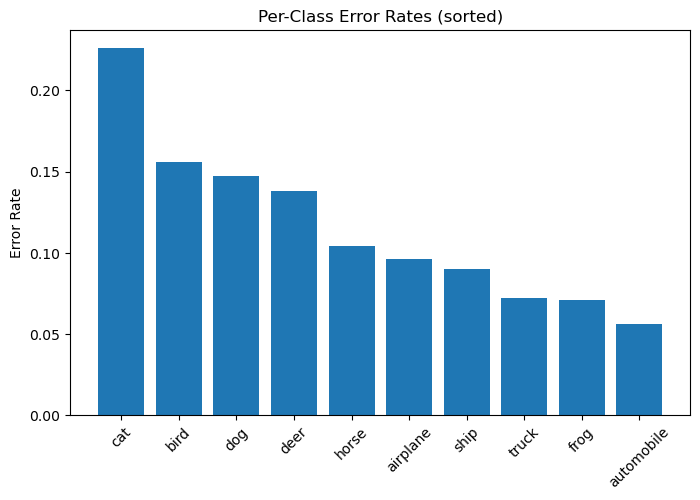

In [28]:
# Sort error_rates by value (descending)
sorted_items = sorted(error_rates.items(), key=lambda x: x[1], reverse=True)

# Unpack keys and values
classes_sorted = [cls for cls, _ in sorted_items]
errors_sorted  = [err for _, err in sorted_items]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(classes_sorted, errors_sorted)
plt.xticks(rotation=45)
plt.ylabel("Error Rate")
plt.title("Per-Class Error Rates (sorted)")
plt.show()

# Possible improvement
* Add augmentation in the preprocessing step
* Compare features extracted at different levels
* Increase the search space of hyperparameters and add cross validation